In [1]:
import torch
import torch.nn as nn
import pandas as pd
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from PIL import Image
import os
import matplotlib.pyplot as plt

image_dir = "data/naodevils/images"
data_dir = "data/naodevils/spqr_autolabel_and_manual_train_patchified.csv"
val_dir = "data/naodevils/spqr_manual_val_patchified.csv"


In [2]:

from math import isnan
class BallDataset(Dataset):
    def __init__(self, data_dir, images_dir, transform=None):
        self.data_dir = data_dir
        self.images_dir = images_dir
        self.transform = transform
        self.df = pd.read_csv(data_dir)

        self.dimension = transform.transforms[0].size[0]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(os.path.join(self.images_dir, row["image"])).convert("L")  # Convert to grayscale
        patch_dim = (row["patch_x"], row["patch_y"], row["patch_x"] + row["patch_size"], row["patch_y"] + row["patch_size"])
        patch = img.crop(patch_dim)
        resize_ratio = self.dimension / row["patch_size"]
        x = (row["center_x"] - row["patch_x"]) * resize_ratio if row["patch_contains_ball"] else float('nan')
        y = (row["center_y"] - row["patch_y"]) * resize_ratio if row["patch_contains_ball"] else float('nan')
        r = row["radius"] * resize_ratio if row["patch_contains_ball"] else float('nan')
        if self.transform:
            patch = self.transform(patch)
        patch = patch * 255.0


        assert isnan(x) or x < 32, (row["patch_x"], row["patch_size"], row["center_x"], x)

        return patch, row["patch_contains_ball"], {"x":x, "y":y, "r":r}

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
])

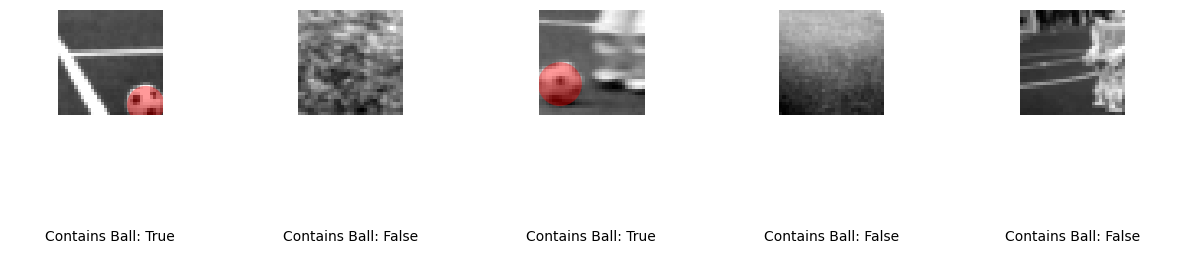

In [3]:
from matplotlib.patches import Circle

dataset = BallDataset(data_dir, image_dir, transform)
validation = BallDataset(val_dir, image_dir, transform)

batch_size = 256
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation, batch_size=batch_size, shuffle=True)

sample = next(iter(data_loader))

num_images = 5

ig, axes = plt.subplots(2, num_images, figsize=(num_images * 3, 3))

for i in range(num_images):
    axes[0, i].imshow(sample[0][i][0], cmap='gray')
    if sample[1][i]:
        c = Circle((sample[2]["x"][i].item(),sample[2]["y"][i].item()), sample[2]["r"][i].item())
        c.set_facecolor((1.0,0.,0.,0.4))
        axes[0, i].add_patch(c)
    axes[0, i].axis('off')
    axes[1, i].text(0.5, 0, f'Contains Ball: {sample[1][i]}', horizontalalignment='center')  # Add text under each image
    axes[1, i].axis('off')  # Turn off axis for text

plt.show()

In [24]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_residual=False):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.use_residual = use_residual

    def forward(self, x):
        z = self.depthwise(x)
        z = self.pointwise(z)
        z = self.bn(z)
        z = self.relu(z) + x if self.use_residual else self.relu(z)
        return z


class BallPerceptor(nn.Module):
    def __init__(self, backbone_size = 9):
        super(BallPerceptor, self).__init__()
        
        self.conv1 = DepthwiseSeparableConv(1, 8, stride=1)
        self.conv2 = DepthwiseSeparableConv(8, 16, stride=1)
        self.conv3 = DepthwiseSeparableConv(16, 32, stride=1)
        
        backbone_layers = []
        for _ in range(backbone_size):
            backbone_layers.append(DepthwiseSeparableConv(32, 32, stride=1,use_residual=True))

        self.backbone = nn.Sequential(*backbone_layers)

        self.pool = nn.MaxPool2d(2, 2)
 
        self.classifier = nn.Sequential(
            nn.Linear(32 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
        self.segmenter = nn.Sequential(
            nn.Linear(32 * 4 * 4, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 3), # x, y, r
        )

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))
        
        x = self.backbone(x)

        feature_map = x.view(-1, 32 * 4 * 4)

        classification = self.classifier(feature_map) if self.training else torch.sigmoid(self.classifier(feature_map))
        segmentation = self.segmenter(feature_map)
        return classification, segmentation

In [25]:
from torch.nn.modules.loss import _Loss

class Circular_DIoU(_Loss):
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super().__init__(size_average, reduce, reduction)

    def intersectionArea(self, X1, Y1, R1, X2, Y2, R2):
        d = torch.sqrt(((X2 - X1) * (X2 - X1)) + ((Y2 - Y1) * (Y2 - Y1)))

        # Case 1: no overlap 
        mask_1 = d > R1 + R2

        # Case 2: One circle is fully within the other
        mask_2 = ( d <= (R1 - R2) ) & ( R1 >= R2 )
        mask_3 = ( d <= (R2 - R1) ) & ( R2 > R1 )

        # Case 3: Partial overlap
        mask_else = ~(mask_1 | mask_2 | mask_3)

        intersection_area = torch.zeros_like(d, dtype=torch.float32)

        intersection_area[mask_2] = torch.pi * R2[mask_2] * R2[mask_2]
        intersection_area[mask_3] = torch.pi * R1[mask_3] * R1[mask_3]

        alpha = torch.acos(((R1[mask_else] * R1[mask_else]) + (d[mask_else] * d[mask_else]) - (R2[mask_else] * R2[mask_else])) / (2 * R1[mask_else] * d[mask_else])) * 2
        beta = torch.acos(((R2[mask_else] * R2[mask_else]) + (d[mask_else] * d[mask_else]) - (R1[mask_else] * R1[mask_else])) / (2 * R2[mask_else] * d[mask_else])) * 2
        
        a1 = (0.5 * beta * R2[mask_else] * R2[mask_else] ) - (0.5 * R2[mask_else] * R2[mask_else] * torch.sin(beta))
        a2 = (0.5 * alpha * R1[mask_else] * R1[mask_else]) - (0.5 * R1[mask_else] * R1[mask_else] * torch.sin(alpha))

        intersection_area[mask_else] = a1 + a2

        return intersection_area

    def forward(self, input, target):
        a1 = torch.pi * torch.pow(input[:,2], 2)
        a2 = torch.pi * torch.pow(target[:,2], 2)

        a1inta2 = self.intersectionArea(input[:,0], input[:,1], input[:,2], target[:,0], target[:,1], target[:,2])

        a1una2 = a1 + a2 - a1inta2

        center_diff = input[:,:2] - target[:,:2]

        center_dist = torch.norm(center_diff, dim=-1)
        D = torch.pow(center_dist, 2)/torch.pow(center_dist + input[:,2] + target[:,2], 2)

        DIoU = 1 - a1inta2/a1una2 + D

        if self.reduction == 'mean':
            return DIoU.mean()
        elif self.reduction == 'sum':
            return DIoU.sum()
        else:
            return DIoU


In [26]:
model = BallPerceptor()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
p_weight = torch.tensor([0.85]).to(device)
classification_criterion = nn.BCEWithLogitsLoss(pos_weight=p_weight)
segmentation_criterion = Circular_DIoU()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

num_epochs = 5
log_rate = 100
eval_rate = 300

r = torch.rand((1, 1, 32, 32))

print(model(r))

model.to(device)


(tensor([[0.1031]], grad_fn=<AddmmBackward0>), tensor([[ 0.1560, -0.0350, -0.5180]], grad_fn=<AddmmBackward0>))


BallPerceptor(
  (conv1): DepthwiseSeparableConv(
    (depthwise): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (pointwise): Conv2d(1, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2): DepthwiseSeparableConv(
    (depthwise): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
    (pointwise): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv3): DepthwiseSeparableConv(
    (depthwise): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
    (pointwise): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (bac

In [7]:
import tqdm
#best_loss = float("inf")
best_loss = 2.883556
PATH = "strong.pt"

if os.path.exists(PATH):
    model.load_state_dict(torch.load(PATH))
    model.to(device)

In [8]:
from sklearn.metrics import f1_score

@torch.no_grad()
def validate(model: nn.Module, detection_weight: float, best_loss: float):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in validation_loader:
            images, labels = data[0].to(device), data[1].float().to(device)
            segmentation_gt = torch.stack((data[2]["x"], data[2]["y"], data[2]["r"]), dim=1).to(device).to(torch.float)
            classification_mask = labels == 1.

            classification, segmentation = model(images)

            val_loss += classification_criterion(classification, labels.unsqueeze(1))                    
            val_loss += detection_weight * segmentation_criterion(segmentation[classification_mask], segmentation_gt[classification_mask])

            predicted = torch.round(classification)
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    model.train()
    accuracy = 100 * correct / total
    val_loss /= total / batch_size

    # Compute F1-score
    f1 = f1_score(all_labels, all_predictions, average='binary')

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), PATH)

    model.train()
    return val_loss, accuracy, f1*100

In [9]:


detection_weight = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in tqdm.tqdm(enumerate(data_loader, 0), total=len(dataset)//batch_size):
        inputs, labels = data[0].to(device), data[1].float().to(device)
        segmentation_gt = torch.stack((data[2]["x"], data[2]["y"], data[2]["r"]), dim=1).to(device).to(torch.float)

        classification_mask = labels == 1.

        optimizer.zero_grad()
        classification, segmentation = model(inputs)
        loss = classification_criterion(classification, labels.unsqueeze(1))

        loss = detection_weight*segmentation_criterion(segmentation[classification_mask], segmentation_gt[classification_mask]) + loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i+1) % log_rate == 0: 
            print('[Epoch %d, Batch %5d] Training loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / log_rate))
            running_loss = 0.0
    
        if (i + 1) % eval_rate == 0:
            val_loss, accuracy, f1 = validate(model, detection_weight, best_loss)
            print('%d iterations --- Accuracy: %f %% --- F1: %f %% --- Loss: %f ' % ((epoch + 1) * (i + 1), accuracy, f1, val_loss))

    val_loss, accuracy, f1 = validate(model, detection_weight, best_loss)
    print('END EPOCH %d --- Accuracy: %f %% --- F1: %f %% ---Loss: %f' % ((epoch + 1), accuracy, f1, val_loss))


print('Finished Training')

  2%|▏         | 100/5269 [03:45<3:14:58,  2.26s/it]

[Epoch 1, Batch   100] Training loss: 2.54285


  4%|▍         | 200/5269 [07:31<3:09:08,  2.24s/it]

[Epoch 1, Batch   200] Training loss: 2.51992


  6%|▌         | 299/5269 [11:13<3:04:54,  2.23s/it]

[Epoch 1, Batch   300] Training loss: 2.48902


  6%|▌         | 300/5269 [14:34<85:15:53, 61.77s/it]

300 iterations --- Accuracy: 91.008381 % --- F1: 64.657438 % --- Loss: 3.342365 


  8%|▊         | 400/5269 [18:18<3:01:12,  2.23s/it] 

[Epoch 1, Batch   400] Training loss: 2.54086


  9%|▉         | 500/5269 [22:02<2:56:46,  2.22s/it]

[Epoch 1, Batch   500] Training loss: 2.50068


 11%|█▏        | 599/5269 [25:42<2:53:38,  2.23s/it]

[Epoch 1, Batch   600] Training loss: 2.46213


 11%|█▏        | 600/5269 [29:04<80:30:22, 62.07s/it]

600 iterations --- Accuracy: 91.222361 % --- F1: 59.326585 % --- Loss: 3.249007 


 13%|█▎        | 700/5269 [32:49<2:50:18,  2.24s/it] 

[Epoch 1, Batch   700] Training loss: 2.48393


 15%|█▌        | 800/5269 [36:32<2:46:13,  2.23s/it]

[Epoch 1, Batch   800] Training loss: 2.43982


 17%|█▋        | 899/5269 [40:13<2:42:14,  2.23s/it]

[Epoch 1, Batch   900] Training loss: 2.48104


 17%|█▋        | 900/5269 [43:34<74:55:05, 61.73s/it]

900 iterations --- Accuracy: 90.651748 % --- F1: 64.762225 % --- Loss: 3.289484 


 19%|█▉        | 1000/5269 [47:20<2:39:47,  2.25s/it]

[Epoch 1, Batch  1000] Training loss: 2.45700


 21%|██        | 1100/5269 [51:03<2:35:16,  2.23s/it]

[Epoch 1, Batch  1100] Training loss: 2.48085


 23%|██▎       | 1199/5269 [54:44<2:31:24,  2.23s/it]

[Epoch 1, Batch  1200] Training loss: 2.42725


 23%|██▎       | 1200/5269 [58:05<70:02:20, 61.97s/it]

1200 iterations --- Accuracy: 91.213445 % --- F1: 64.922584 % --- Loss: 3.268110 


 25%|██▍       | 1300/5269 [1:01:48<2:28:09,  2.24s/it]

[Epoch 1, Batch  1300] Training loss: 2.48481


 27%|██▋       | 1400/5269 [1:05:32<2:23:55,  2.23s/it]

[Epoch 1, Batch  1400] Training loss: 2.44902


 28%|██▊       | 1499/5269 [1:09:16<2:20:16,  2.23s/it]

[Epoch 1, Batch  1500] Training loss: 2.41398


 28%|██▊       | 1500/5269 [1:12:37<64:35:44, 61.70s/it]

1500 iterations --- Accuracy: 91.008381 % --- F1: 65.609548 % --- Loss: 3.390665 


 30%|███       | 1600/5269 [1:16:21<2:16:55,  2.24s/it] 

[Epoch 1, Batch  1600] Training loss: 2.38055


 32%|███▏      | 1700/5269 [1:20:04<2:12:53,  2.23s/it]

[Epoch 1, Batch  1700] Training loss: 2.44932


 34%|███▍      | 1799/5269 [1:23:45<2:09:14,  2.23s/it]

[Epoch 1, Batch  1800] Training loss: 2.39880


 34%|███▍      | 1800/5269 [1:27:06<59:24:14, 61.65s/it]

1800 iterations --- Accuracy: 90.816690 % --- F1: 65.261383 % --- Loss: 3.232681 


 36%|███▌      | 1900/5269 [1:30:49<2:05:35,  2.24s/it] 

[Epoch 1, Batch  1900] Training loss: 2.41971


 38%|███▊      | 2000/5269 [1:34:33<2:01:30,  2.23s/it]

[Epoch 1, Batch  2000] Training loss: 2.37320


 40%|███▉      | 2099/5269 [1:38:14<1:57:52,  2.23s/it]

[Epoch 1, Batch  2100] Training loss: 2.42901


 40%|███▉      | 2100/5269 [1:41:35<54:19:24, 61.71s/it]

2100 iterations --- Accuracy: 91.418509 % --- F1: 65.107848 % --- Loss: 3.180166 


 42%|████▏     | 2200/5269 [1:45:18<1:54:19,  2.24s/it] 

[Epoch 1, Batch  2200] Training loss: 2.37221


 44%|████▎     | 2300/5269 [1:49:01<1:50:44,  2.24s/it]

[Epoch 1, Batch  2300] Training loss: 2.37779


 46%|████▌     | 2399/5269 [1:52:42<1:47:14,  2.24s/it]

[Epoch 1, Batch  2400] Training loss: 2.38885


 46%|████▌     | 2400/5269 [1:56:03<49:09:16, 61.68s/it]

2400 iterations --- Accuracy: 90.914765 % --- F1: 64.970780 % --- Loss: 3.221183 


 47%|████▋     | 2500/5269 [1:59:46<1:43:26,  2.24s/it] 

[Epoch 1, Batch  2500] Training loss: 2.40193


 49%|████▉     | 2600/5269 [2:03:30<1:39:33,  2.24s/it]

[Epoch 1, Batch  2600] Training loss: 2.41140


 51%|█████     | 2699/5269 [2:07:14<1:36:21,  2.25s/it]

[Epoch 1, Batch  2700] Training loss: 2.39260


 51%|█████     | 2700/5269 [2:10:34<44:01:05, 61.68s/it]

2700 iterations --- Accuracy: 91.405136 % --- F1: 65.583720 % --- Loss: 3.247399 


 53%|█████▎    | 2800/5269 [2:14:17<1:31:55,  2.23s/it] 

[Epoch 1, Batch  2800] Training loss: 2.36627


 55%|█████▌    | 2900/5269 [2:18:00<1:27:30,  2.22s/it]

[Epoch 1, Batch  2900] Training loss: 2.31025


 57%|█████▋    | 2999/5269 [2:21:40<1:24:13,  2.23s/it]

[Epoch 1, Batch  3000] Training loss: 2.37464


 57%|█████▋    | 3000/5269 [2:25:00<38:51:26, 61.65s/it]

3000 iterations --- Accuracy: 91.886591 % --- F1: 65.840841 % --- Loss: 3.182055 


 59%|█████▉    | 3100/5269 [2:28:43<1:20:35,  2.23s/it] 

[Epoch 1, Batch  3100] Training loss: 2.38521


 61%|██████    | 3200/5269 [2:32:26<1:16:46,  2.23s/it]

[Epoch 1, Batch  3200] Training loss: 2.35030


 63%|██████▎   | 3299/5269 [2:36:06<1:13:04,  2.23s/it]

[Epoch 1, Batch  3300] Training loss: 2.31219


 63%|██████▎   | 3300/5269 [2:39:27<33:42:57, 61.64s/it]

3300 iterations --- Accuracy: 91.792974 % --- F1: 67.060297 % --- Loss: 3.242974 


 65%|██████▍   | 3400/5269 [2:43:11<1:09:35,  2.23s/it] 

[Epoch 1, Batch  3400] Training loss: 2.39137


 66%|██████▋   | 3500/5269 [2:46:55<1:05:50,  2.23s/it]

[Epoch 1, Batch  3500] Training loss: 2.33418


 68%|██████▊   | 3599/5269 [2:50:36<1:02:03,  2.23s/it]

[Epoch 1, Batch  3600] Training loss: 2.34065


 68%|██████▊   | 3600/5269 [2:53:56<28:35:54, 61.69s/it]

3600 iterations --- Accuracy: 91.717190 % --- F1: 63.725107 % --- Loss: 3.127354 


 70%|███████   | 3700/5269 [2:57:42<58:19,  2.23s/it]   

[Epoch 1, Batch  3700] Training loss: 2.34566


 72%|███████▏  | 3800/5269 [3:01:25<54:49,  2.24s/it]

[Epoch 1, Batch  3800] Training loss: 2.33851


 74%|███████▍  | 3899/5269 [3:05:06<50:55,  2.23s/it]

[Epoch 1, Batch  3900] Training loss: 2.28932


 74%|███████▍  | 3900/5269 [3:08:26<23:26:47, 61.66s/it]

3900 iterations --- Accuracy: 91.775143 % --- F1: 67.059454 % --- Loss: 3.153967 


 76%|███████▌  | 4000/5269 [3:12:10<47:10,  2.23s/it]   

[Epoch 1, Batch  4000] Training loss: 2.30400


 78%|███████▊  | 4100/5269 [3:15:53<43:19,  2.22s/it]

[Epoch 1, Batch  4100] Training loss: 2.29220


 80%|███████▉  | 4199/5269 [3:19:33<39:43,  2.23s/it]

[Epoch 1, Batch  4200] Training loss: 2.26919


 80%|███████▉  | 4200/5269 [3:22:54<18:18:34, 61.66s/it]

4200 iterations --- Accuracy: 91.944544 % --- F1: 65.162907 % --- Loss: 3.126486 


 82%|████████▏ | 4300/5269 [3:26:37<35:54,  2.22s/it]   

[Epoch 1, Batch  4300] Training loss: 2.26135


 84%|████████▎ | 4400/5269 [3:30:22<32:13,  2.23s/it]

[Epoch 1, Batch  4400] Training loss: 2.28529


 85%|████████▌ | 4499/5269 [3:34:03<28:32,  2.22s/it]

[Epoch 1, Batch  4500] Training loss: 2.27695


 85%|████████▌ | 4500/5269 [3:37:24<13:10:26, 61.67s/it]

4500 iterations --- Accuracy: 91.703816 % --- F1: 65.746365 % --- Loss: 3.101076 


 87%|████████▋ | 4600/5269 [3:41:07<25:01,  2.24s/it]   

[Epoch 1, Batch  4600] Training loss: 2.29460


 89%|████████▉ | 4700/5269 [3:44:50<21:09,  2.23s/it]

[Epoch 1, Batch  4700] Training loss: 2.30502


 91%|█████████ | 4799/5269 [3:48:32<17:23,  2.22s/it]

[Epoch 1, Batch  4800] Training loss: 2.26440


 91%|█████████ | 4800/5269 [3:51:52<8:01:42, 61.63s/it]

4800 iterations --- Accuracy: 91.645863 % --- F1: 66.972154 % --- Loss: 3.178334 


 93%|█████████▎| 4900/5269 [3:55:34<13:41,  2.23s/it]  

[Epoch 1, Batch  4900] Training loss: 2.25965


 95%|█████████▍| 5000/5269 [3:59:20<09:59,  2.23s/it]

[Epoch 1, Batch  5000] Training loss: 2.26589


 97%|█████████▋| 5099/5269 [4:03:02<06:18,  2.23s/it]

[Epoch 1, Batch  5100] Training loss: 2.27927


 97%|█████████▋| 5100/5269 [4:06:23<2:54:30, 61.96s/it]

5100 iterations --- Accuracy: 91.151034 % --- F1: 68.050861 % --- Loss: 3.100561 


 99%|█████████▊| 5200/5269 [4:10:08<02:34,  2.24s/it]  

[Epoch 1, Batch  5200] Training loss: 2.26571


5270it [4:12:42,  2.88s/it]                          


END EPOCH 1 --- Accuracy: 91.712732 % --- F1: 64.570231 % ---Loss: 3.056045


  2%|▏         | 100/5269 [03:43<3:12:25,  2.23s/it]

[Epoch 2, Batch   100] Training loss: 2.23658


  4%|▍         | 200/5269 [07:25<3:08:22,  2.23s/it]

[Epoch 2, Batch   200] Training loss: 2.25718


  6%|▌         | 299/5269 [11:08<3:04:45,  2.23s/it]

[Epoch 2, Batch   300] Training loss: 2.20964


  6%|▌         | 300/5269 [14:28<85:05:15, 61.65s/it]

600 iterations --- Accuracy: 92.064907 % --- F1: 66.963623 % --- Loss: 3.049550 


  8%|▊         | 400/5269 [18:11<3:00:34,  2.23s/it] 

[Epoch 2, Batch   400] Training loss: 2.23905


  9%|▉         | 500/5269 [21:54<2:56:52,  2.23s/it]

[Epoch 2, Batch   500] Training loss: 2.22935


 11%|█▏        | 599/5269 [25:35<2:53:24,  2.23s/it]

[Epoch 2, Batch   600] Training loss: 2.21966


 11%|█▏        | 600/5269 [28:55<79:58:45, 61.67s/it]

1200 iterations --- Accuracy: 92.109486 % --- F1: 66.553288 % --- Loss: 3.064562 


 13%|█▎        | 700/5269 [32:39<2:49:22,  2.22s/it] 

[Epoch 2, Batch   700] Training loss: 2.25223


 15%|█▌        | 800/5269 [36:21<2:45:52,  2.23s/it]

[Epoch 2, Batch   800] Training loss: 2.23952


 17%|█▋        | 899/5269 [40:02<2:42:17,  2.23s/it]

[Epoch 2, Batch   900] Training loss: 2.21525


 17%|█▋        | 900/5269 [43:22<74:50:05, 61.66s/it]

1800 iterations --- Accuracy: 91.485378 % --- F1: 68.973359 % --- Loss: 3.056854 


 19%|█▉        | 1000/5269 [47:05<2:39:05,  2.24s/it]

[Epoch 2, Batch  1000] Training loss: 2.18249


 21%|██        | 1100/5269 [50:49<2:34:31,  2.22s/it]

[Epoch 2, Batch  1100] Training loss: 2.22394


 23%|██▎       | 1199/5269 [54:29<2:30:59,  2.23s/it]

[Epoch 2, Batch  1200] Training loss: 2.17721


 23%|██▎       | 1200/5269 [57:51<70:05:31, 62.01s/it]

2400 iterations --- Accuracy: 91.654779 % --- F1: 68.249661 % --- Loss: 3.095834 


 25%|██▍       | 1300/5269 [1:01:34<2:27:36,  2.23s/it]

[Epoch 2, Batch  1300] Training loss: 2.18967


 27%|██▋       | 1400/5269 [1:05:16<2:22:54,  2.22s/it]

[Epoch 2, Batch  1400] Training loss: 2.23902


 28%|██▊       | 1499/5269 [1:08:57<2:19:35,  2.22s/it]

[Epoch 2, Batch  1500] Training loss: 2.20342


 28%|██▊       | 1500/5269 [1:12:17<64:29:36, 61.60s/it]

3000 iterations --- Accuracy: 91.980207 % --- F1: 67.972227 % --- Loss: 3.047851 


 30%|███       | 1600/5269 [1:15:59<2:16:05,  2.23s/it] 

[Epoch 2, Batch  1600] Training loss: 2.22886


 32%|███▏      | 1700/5269 [1:19:45<2:12:17,  2.22s/it]

[Epoch 2, Batch  1700] Training loss: 2.23203


 34%|███▍      | 1799/5269 [1:23:27<2:08:19,  2.22s/it]

[Epoch 2, Batch  1800] Training loss: 2.25524


 34%|███▍      | 1800/5269 [1:26:49<59:42:56, 61.97s/it]

3600 iterations --- Accuracy: 91.917796 % --- F1: 66.910020 % --- Loss: 3.030694 


 36%|███▌      | 1900/5269 [1:30:33<2:05:27,  2.23s/it] 

[Epoch 2, Batch  1900] Training loss: 2.21781


 38%|███▊      | 2000/5269 [1:34:17<2:01:39,  2.23s/it]

[Epoch 2, Batch  2000] Training loss: 2.15086


 40%|███▉      | 2099/5269 [1:37:58<1:58:11,  2.24s/it]

[Epoch 2, Batch  2100] Training loss: 2.24292


 40%|███▉      | 2100/5269 [1:41:18<54:16:58, 61.67s/it]

4200 iterations --- Accuracy: 92.252140 % --- F1: 68.027962 % --- Loss: 3.030168 


 42%|████▏     | 2200/5269 [1:45:02<1:54:12,  2.23s/it] 

[Epoch 2, Batch  2200] Training loss: 2.15601


 44%|████▎     | 2300/5269 [1:48:46<1:51:07,  2.25s/it]

[Epoch 2, Batch  2300] Training loss: 2.14114


 46%|████▌     | 2399/5269 [1:52:27<1:46:42,  2.23s/it]

[Epoch 2, Batch  2400] Training loss: 2.19670


 46%|████▌     | 2400/5269 [1:55:48<49:09:01, 61.67s/it]

4800 iterations --- Accuracy: 91.788516 % --- F1: 69.462865 % --- Loss: 3.067619 


 47%|████▋     | 2500/5269 [1:59:31<1:43:21,  2.24s/it] 

[Epoch 2, Batch  2500] Training loss: 2.15075


 49%|████▉     | 2600/5269 [2:03:14<1:38:53,  2.22s/it]

[Epoch 2, Batch  2600] Training loss: 2.18001


 51%|█████     | 2699/5269 [2:06:55<1:35:51,  2.24s/it]

[Epoch 2, Batch  2700] Training loss: 2.15897


 51%|█████     | 2700/5269 [2:10:16<43:59:21, 61.64s/it]

5400 iterations --- Accuracy: 92.047076 % --- F1: 68.085868 % --- Loss: 2.973866 


 53%|█████▎    | 2800/5269 [2:13:59<1:32:54,  2.26s/it] 

[Epoch 2, Batch  2800] Training loss: 2.18246


 55%|█████▌    | 2900/5269 [2:17:43<1:28:38,  2.25s/it]

[Epoch 2, Batch  2900] Training loss: 2.15436


 57%|█████▋    | 2999/5269 [2:21:24<1:24:12,  2.23s/it]

[Epoch 2, Batch  3000] Training loss: 2.13972


 57%|█████▋    | 3000/5269 [2:24:44<38:51:10, 61.64s/it]

6000 iterations --- Accuracy: 92.229850 % --- F1: 65.423527 % --- Loss: 2.979200 


 59%|█████▉    | 3100/5269 [2:28:28<1:21:14,  2.25s/it] 

[Epoch 2, Batch  3100] Training loss: 2.13757


 61%|██████    | 3200/5269 [2:32:11<1:16:34,  2.22s/it]

[Epoch 2, Batch  3200] Training loss: 2.17613


 63%|██████▎   | 3299/5269 [2:35:53<1:13:16,  2.23s/it]

[Epoch 2, Batch  3300] Training loss: 2.17723


 63%|██████▎   | 3300/5269 [2:39:12<33:38:15, 61.50s/it]

6600 iterations --- Accuracy: 92.127318 % --- F1: 68.225981 % --- Loss: 3.069283 


 65%|██████▍   | 3400/5269 [2:42:57<1:09:28,  2.23s/it] 

[Epoch 2, Batch  3400] Training loss: 2.15033


 66%|██████▋   | 3500/5269 [2:46:39<1:05:41,  2.23s/it]

[Epoch 2, Batch  3500] Training loss: 2.14793


 68%|██████▊   | 3599/5269 [2:50:21<1:01:40,  2.22s/it]

[Epoch 2, Batch  3600] Training loss: 2.11748


 68%|██████▊   | 3600/5269 [2:53:42<28:36:08, 61.69s/it]

7200 iterations --- Accuracy: 92.310093 % --- F1: 68.073293 % --- Loss: 3.002037 


 70%|███████   | 3700/5269 [2:57:26<58:19,  2.23s/it]   

[Epoch 2, Batch  3700] Training loss: 2.17714


 72%|███████▏  | 3800/5269 [3:01:10<54:32,  2.23s/it]  

[Epoch 2, Batch  3800] Training loss: 2.12416


 74%|███████▍  | 3899/5269 [3:04:51<50:58,  2.23s/it]

[Epoch 2, Batch  3900] Training loss: 2.16356


 74%|███████▍  | 3900/5269 [3:08:11<23:26:17, 61.63s/it]

7800 iterations --- Accuracy: 91.703816 % --- F1: 68.853556 % --- Loss: 2.982321 


 76%|███████▌  | 4000/5269 [3:11:57<47:10,  2.23s/it]   

[Epoch 2, Batch  4000] Training loss: 2.15138


 78%|███████▊  | 4100/5269 [3:15:42<43:21,  2.23s/it]

[Epoch 2, Batch  4100] Training loss: 2.13254


 80%|███████▉  | 4199/5269 [3:19:23<39:51,  2.24s/it]

[Epoch 2, Batch  4200] Training loss: 2.12698


 80%|███████▉  | 4200/5269 [3:22:45<18:24:45, 62.01s/it]

8400 iterations --- Accuracy: 92.501783 % --- F1: 68.204159 % --- Loss: 2.975178 


 82%|████████▏ | 4300/5269 [3:26:27<35:48,  2.22s/it]   

[Epoch 2, Batch  4300] Training loss: 2.12399


 84%|████████▎ | 4400/5269 [3:30:10<32:16,  2.23s/it]

[Epoch 2, Batch  4400] Training loss: 2.11213


 85%|████████▌ | 4499/5269 [3:33:51<28:28,  2.22s/it]

[Epoch 2, Batch  4500] Training loss: 2.10929


 85%|████████▌ | 4500/5269 [3:37:15<13:22:11, 62.59s/it]

9000 iterations --- Accuracy: 92.100571 % --- F1: 68.857645 % --- Loss: 2.958749 


 87%|████████▋ | 4600/5269 [3:40:58<24:49,  2.23s/it]   

[Epoch 2, Batch  4600] Training loss: 2.09941


 89%|████████▉ | 4700/5269 [3:44:44<21:17,  2.24s/it]

[Epoch 2, Batch  4700] Training loss: 2.10472


 91%|█████████ | 4799/5269 [3:48:27<17:32,  2.24s/it]

[Epoch 2, Batch  4800] Training loss: 2.08935


 91%|█████████ | 4800/5269 [3:51:50<8:06:46, 62.27s/it]

9600 iterations --- Accuracy: 91.641405 % --- F1: 69.277405 % --- Loss: 2.933024 


 93%|█████████▎| 4900/5269 [3:55:33<13:39,  2.22s/it]  

[Epoch 2, Batch  4900] Training loss: 2.11722


 95%|█████████▍| 5000/5269 [3:59:16<09:58,  2.23s/it]

[Epoch 2, Batch  5000] Training loss: 2.08387


 97%|█████████▋| 5099/5269 [4:03:01<06:20,  2.24s/it]

[Epoch 2, Batch  5100] Training loss: 2.17621


 97%|█████████▋| 5100/5269 [4:06:21<2:53:39, 61.65s/it]

10200 iterations --- Accuracy: 92.332382 % --- F1: 68.997837 % --- Loss: 2.935776 


 99%|█████████▊| 5200/5269 [4:10:04<02:33,  2.23s/it]  

[Epoch 2, Batch  5200] Training loss: 2.13195


5270it [4:12:38,  2.88s/it]                          


END EPOCH 2 --- Accuracy: 92.354672 % --- F1: 69.270740 % ---Loss: 3.007961


  2%|▏         | 100/5269 [03:43<3:11:27,  2.22s/it]

[Epoch 3, Batch   100] Training loss: 2.14512


  4%|▍         | 200/5269 [07:26<3:08:25,  2.23s/it]

[Epoch 3, Batch   200] Training loss: 2.07940


  6%|▌         | 299/5269 [11:07<3:04:44,  2.23s/it]

[Epoch 3, Batch   300] Training loss: 2.07314


  6%|▌         | 300/5269 [14:27<85:04:31, 61.64s/it]

900 iterations --- Accuracy: 92.751427 % --- F1: 70.154185 % --- Loss: 2.933124 


  8%|▊         | 400/5269 [18:11<3:04:17,  2.27s/it] 

[Epoch 3, Batch   400] Training loss: 2.05611


  9%|▉         | 500/5269 [21:57<2:57:51,  2.24s/it]

[Epoch 3, Batch   500] Training loss: 2.10357


 11%|█▏        | 599/5269 [25:38<2:53:17,  2.23s/it]

[Epoch 3, Batch   600] Training loss: 2.11354


 11%|█▏        | 600/5269 [28:59<80:18:00, 61.91s/it]

1800 iterations --- Accuracy: 92.363588 % --- F1: 70.541702 % --- Loss: 2.936171 


 13%|█▎        | 700/5269 [32:43<2:50:08,  2.23s/it] 

[Epoch 3, Batch   700] Training loss: 2.08384


 15%|█▌        | 800/5269 [36:27<2:46:36,  2.24s/it]

[Epoch 3, Batch   800] Training loss: 2.04219


 17%|█▋        | 899/5269 [40:08<2:41:50,  2.22s/it]

[Epoch 3, Batch   900] Training loss: 2.07750


 17%|█▋        | 900/5269 [43:28<74:40:38, 61.53s/it]

2700 iterations --- Accuracy: 92.448288 % --- F1: 68.253373 % --- Loss: 2.909823 


 19%|█▉        | 1000/5269 [47:12<2:39:36,  2.24s/it]

[Epoch 3, Batch  1000] Training loss: 2.09243


 21%|██        | 1100/5269 [50:58<2:45:44,  2.39s/it]

[Epoch 3, Batch  1100] Training loss: 2.07762


 23%|██▎       | 1199/5269 [54:40<2:32:09,  2.24s/it]

[Epoch 3, Batch  1200] Training loss: 2.06086


 23%|██▎       | 1200/5269 [58:01<69:45:01, 61.71s/it]

3600 iterations --- Accuracy: 92.635521 % --- F1: 69.654666 % --- Loss: 2.890525 


 25%|██▍       | 1300/5269 [1:01:44<2:28:15,  2.24s/it]

[Epoch 3, Batch  1300] Training loss: 2.10735


 27%|██▋       | 1400/5269 [1:05:30<2:46:36,  2.58s/it]

[Epoch 3, Batch  1400] Training loss: 2.06035


 28%|██▊       | 1499/5269 [1:09:11<2:20:09,  2.23s/it]

[Epoch 3, Batch  1500] Training loss: 2.10215


 28%|██▊       | 1500/5269 [1:12:35<65:37:07, 62.68s/it]

4500 iterations --- Accuracy: 92.524073 % --- F1: 69.614061 % --- Loss: 2.951760 


 30%|███       | 1600/5269 [1:16:18<2:16:18,  2.23s/it] 

[Epoch 3, Batch  1600] Training loss: 2.07401


 32%|███▏      | 1700/5269 [1:20:03<2:27:40,  2.48s/it]

[Epoch 3, Batch  1700] Training loss: 2.06589


 34%|███▍      | 1799/5269 [1:23:43<2:08:52,  2.23s/it]

[Epoch 3, Batch  1800] Training loss: 2.06528


 34%|███▍      | 1800/5269 [1:27:04<59:40:17, 61.92s/it]

5400 iterations --- Accuracy: 92.073823 % --- F1: 70.247657 % --- Loss: 2.960834 


 36%|███▌      | 1900/5269 [1:30:49<2:05:18,  2.23s/it] 

[Epoch 3, Batch  1900] Training loss: 2.03645


 38%|███▊      | 2000/5269 [1:34:32<2:01:25,  2.23s/it]

[Epoch 3, Batch  2000] Training loss: 2.02534


 40%|███▉      | 2099/5269 [1:38:13<1:57:47,  2.23s/it]

[Epoch 3, Batch  2100] Training loss: 2.04428


 40%|███▉      | 2100/5269 [1:41:34<54:28:51, 61.89s/it]

6300 iterations --- Accuracy: 92.501783 % --- F1: 71.277322 % --- Loss: 2.886565 


 42%|████▏     | 2200/5269 [1:45:17<1:54:35,  2.24s/it] 

[Epoch 3, Batch  2200] Training loss: 2.06488


 44%|████▎     | 2300/5269 [1:49:00<1:50:57,  2.24s/it]

[Epoch 3, Batch  2300] Training loss: 2.04143


 46%|████▌     | 2399/5269 [1:52:41<1:46:35,  2.23s/it]

[Epoch 3, Batch  2400] Training loss: 2.04857


 46%|████▌     | 2400/5269 [1:56:01<49:07:49, 61.65s/it]

7200 iterations --- Accuracy: 92.359130 % --- F1: 70.958997 % --- Loss: 2.889404 


 47%|████▋     | 2500/5269 [1:59:44<1:42:51,  2.23s/it] 

[Epoch 3, Batch  2500] Training loss: 2.01015


 49%|████▉     | 2600/5269 [2:03:28<1:39:02,  2.23s/it]

[Epoch 3, Batch  2600] Training loss: 2.02257


 51%|█████     | 2699/5269 [2:07:09<1:35:18,  2.23s/it]

[Epoch 3, Batch  2700] Training loss: 2.04632


 51%|█████     | 2700/5269 [2:10:30<44:15:09, 62.01s/it]

8100 iterations --- Accuracy: 92.622147 % --- F1: 69.346175 % --- Loss: 2.883556 


 53%|█████▎    | 2800/5269 [2:14:14<1:31:51,  2.23s/it] 

[Epoch 3, Batch  2800] Training loss: 2.04586


 55%|█████▌    | 2900/5269 [2:17:57<1:28:22,  2.24s/it]

[Epoch 3, Batch  2900] Training loss: 2.03875


 57%|█████▋    | 2999/5269 [2:21:38<1:24:14,  2.23s/it]

[Epoch 3, Batch  3000] Training loss: 2.01411


 57%|█████▋    | 3000/5269 [2:24:58<38:46:19, 61.52s/it]

9000 iterations --- Accuracy: 92.653352 % --- F1: 68.000000 % --- Loss: 2.902757 


 59%|█████▉    | 3100/5269 [2:28:41<1:20:25,  2.22s/it] 

[Epoch 3, Batch  3100] Training loss: 2.08165


 59%|█████▉    | 3124/5269 [2:29:35<1:42:42,  2.87s/it]


KeyboardInterrupt: 

END EPOCH 1 ---  --- 

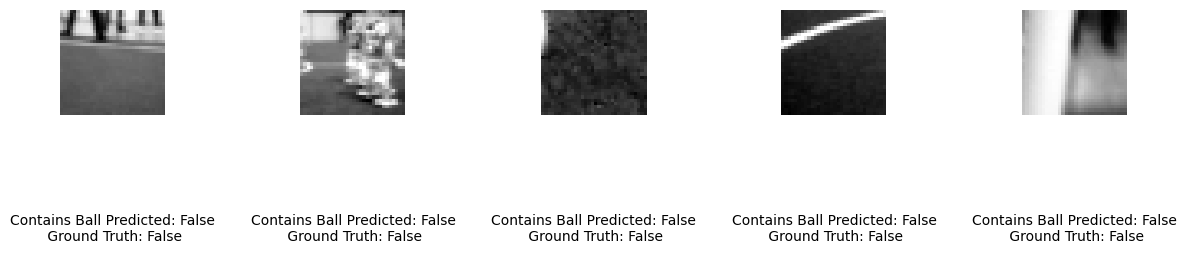

In [27]:
PATH = "strong.pt"

model.load_state_dict(torch.load(PATH))
model.to(torch.device("cpu"))

num_images = 5
threshold = 0.5
sample = next(iter(validation_loader))

preds = model(sample[0])

detection, segmentation = preds

ig, axes = plt.subplots(2, num_images, figsize=(num_images * 3, 3))


for i in range(num_images):
    axes[0, i].imshow(sample[0][i][0], cmap='gray')
    if detection[i] > threshold:
        c = Circle((segmentation[i][0].item(),segmentation[i][1].item()), segmentation[i][2].item())
        c.set_facecolor((1.0,0.,0.,0.4))
        axes[0, i].add_patch(c)
    axes[0, i].axis('off')
    axes[1, i].text(0.5, 0, f'Contains Ball Predicted: {detection[i].item()> threshold}\n Ground Truth: {sample[1][i]}', horizontalalignment='center')  # Add text under each image
    axes[1, i].axis('off')  # Turn off axis for text

plt.show()


In [ ]:
import time
import onnx 
import onnxruntime as ort
import os
import tqdm
def measure_inference_time(model, input_size=(1, 1, 32, 32), device='cpu', num_runs=1000):
    input_tensor = torch.randn(input_size)
    model.to(device)
    
    torch.onnx.export(model, input_tensor, "tmp.onnx", export_params=True, opset_version=12)

    onnx_model = onnx.load("tmp.onnx")
    onnx.checker.check_model(onnx_model)

    onnx_input = {onnx_model.graph.input[0].name: input_tensor.detach().cpu().numpy()}
    
    onnx_session = ort.InferenceSession('tmp.onnx')

    total_time = 0
    for _ in tqdm.tqdm(range(num_runs)):
        start_time = time.time()
        onnx_session.run(None, onnx_input)
        total_time += time.time() - start_time

    avg_time = total_time / num_runs
    os.remove("tmp.onnx")
    return avg_time

measure_inference_time(model)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:09<00:00, 107.12it/s]


0.008591138362884521

In [30]:
dummy_input = torch.randn(1, 1, 32, 32)

torch.onnx.export(model, dummy_input, "model.onnx", 
                  input_names=['input'], output_names=['output_classification', 'output_detection'], 
                  dynamic_axes={'input': {0: 'batch_size'}, 'output_classification': {0: 'batch_size'}, 'output_detection': {0: 'batch_size'}})

In [ ]:
!pip install onnxruntime

  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 29.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 10.0 MB/s eta 0:00:00
Using cached flatbuffers-24.3.25-py2.py3-none-any.whl (26 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 19.5 MB/s eta 0:00:00
